In [124]:
import pystac_client
import planetary_computer
import geopandas as gpd
import rioxarray
import matplotlib.pyplot as plt


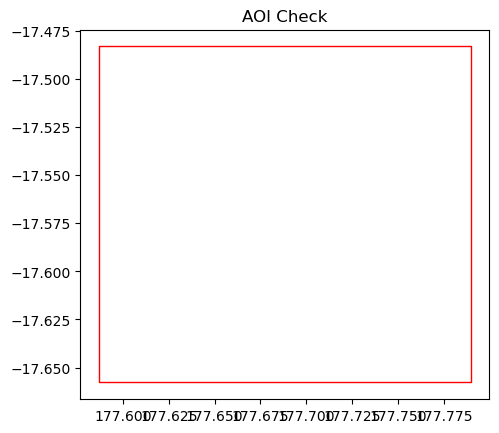

In [125]:
# Constants
MSPC_CATALOG = "https://planetarycomputer.microsoft.com/api/stac/v1/"
COLLECTION = "cop-dem-glo-30"
elevation_threshold: float = 10.0

# Load your AOI
# Replace with actual file path or create GeoDataFrame
aoi_gdf = gpd.read_file("Ba3_Fiji.geojson")
aoi_gdf.plot(edgecolor="red", facecolor="none")
plt.title("AOI Check")
plt.show()


In [126]:
stac_client = pystac_client.Client.open(MSPC_CATALOG)

search = stac_client.search(
    collections=[COLLECTION],
    intersects=aoi_gdf.geometry.unary_union,
    max_items=1
)

item = next(search.get_items())
print(f"STAC item ID: {item.id}")

# Get signed asset URL
asset_href = planetary_computer.sign(item.assets["data"].href)
print(asset_href)


/tmp/ipykernel_5299/2498274153.py:5: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  intersects=aoi_gdf.geometry.unary_union,
/srv/conda/envs/notebook/lib/python3.10/site-packages/pystac_client/item_search.py:881: FutureWarning: get_items() is deprecated, use items() instead
  warnings.warn(


STAC item ID: Copernicus_DSM_COG_10_S18_00_E177_00_DEM
https://elevationeuwest.blob.core.windows.net/copernicus-dem/COP30_hh/Copernicus_DSM_COG_10_S18_00_E177_00_DEM.tif?st=2025-07-07T04%3A31%3A15Z&se=2025-07-08T05%3A16%3A15Z&sp=rl&sv=2024-05-04&sr=c&skoid=9c8ff44a-6a2c-4dfb-b298-1c9212f64d9a&sktid=72f988bf-86f1-41af-91ab-2d7cd011db47&skt=2025-07-08T03%3A46%3A30Z&ske=2025-07-15T03%3A46%3A30Z&sks=b&skv=2024-05-04&sig=8MgOH/Y6u0cE3jEOqbPs8FKDXpaI/t2CL2QM21vbClI%3D


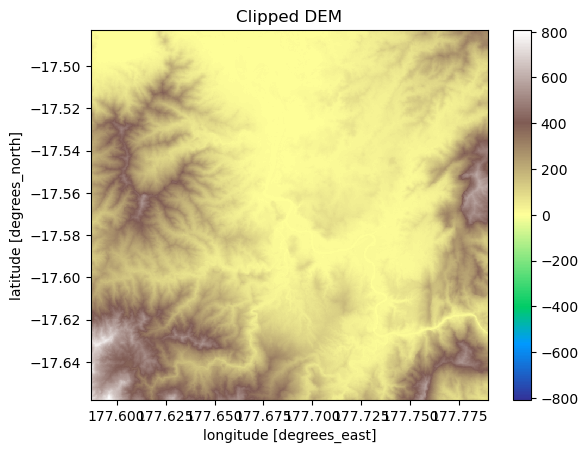

In [127]:
# Open the DEM raster
dem = rioxarray.open_rasterio(asset_href).squeeze()

# Clip to AOI
dem_clipped = dem.rio.clip(aoi_gdf.geometry, aoi_gdf.crs, drop=True)

# Plot to check
dem_clipped.plot(cmap="terrain")
plt.title("Clipped DEM")
plt.show()


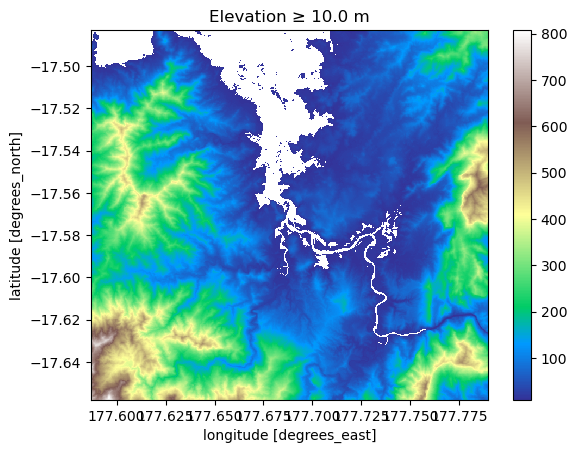

In [128]:
# Mask elevation below threshold
masked = dem_clipped.where(dem_clipped >= elevation_threshold)

# Plot masked elevation
masked.plot(cmap="terrain")
plt.title(f"Elevation ≥ {elevation_threshold} m")
plt.show()


In [129]:
masked = masked.compute()
masked

<xarray.DataArray (y: 630, x: 730)> Size: 2MB
array([[       nan,        nan,        nan, ..., 287.98105 , 286.053   ,
        284.6595  ],
       [       nan,        nan,        nan, ..., 287.80045 , 286.82825 ,
        288.70813 ],
       [       nan,        nan,        nan, ..., 285.6865  , 285.80957 ,
        288.92474 ],
       ...,
       [724.2318  , 721.15125 , 717.7901  , ...,  83.93115 ,  88.0866  ,
         89.12781 ],
       [731.6039  , 728.82715 , 721.8574  , ...,  81.53724 ,  86.05938 ,
         87.13393 ],
       [737.8632  , 732.87476 , 722.73236 , ...,  77.987366,  81.77601 ,
         81.04183 ]], dtype=float32)
Coordinates:
    band         int64 8B 1
  * x            (x) float64 6kB 177.6 177.6 177.6 177.6 ... 177.8 177.8 177.8
  * y            (y) float64 5kB -17.48 -17.48 -17.48 ... -17.66 -17.66 -17.66
    spatial_ref  int64 8B 0
Attributes:
    AREA_OR_POINT:  Point
    scale_factor:   1.0
    add_offset:     0.0

In [130]:
mean_elev = float(masked.mean().values)
min_elev = float(masked.min().values)
max_elev = float(masked.max().values)
valid_pixel_count = int(masked.notnull().sum().values)

print(f"Elevation >= {elevation_threshold} m stats:")
print(f"  Mean: {mean_elev:.2f} m")
print(f"  Min: {min_elev:.2f} m")
print(f"  Max: {max_elev:.2f} m")
print(f"  Valid pixel count: {valid_pixel_count}")


Elevation >= 10.0 m stats:
  Mean: 156.83 m
  Min: 10.00 m
  Max: 807.61 m
  Valid pixel count: 413125


In [131]:
masked.rio.to_raster("masked_elevation_above_thresholdWesternBa3_17.tif")
print("Masked raster saved as masked_elevation_above_threshold.tif")

Masked raster saved as masked_elevation_above_threshold.tif


In [132]:
from pystac_client import Client
from odc.stac import load
from pystac import Collection


In [133]:
# Connect to the STAC catalog
catalog = "https://stac.digitalearthpacific.org"
client = Client.open(catalog)

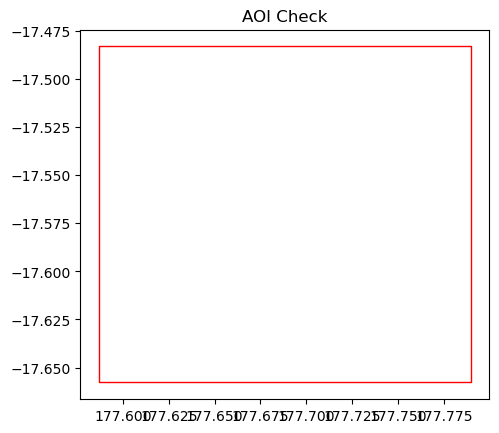

In [134]:
# Define bounding box – should match your elevation mask area
aoi_gdf = gpd.read_file("Ba3_Fiji.geojson")
aoi_gdf.plot(edgecolor="red", facecolor="none")
plt.title("AOI Check")
plt.show()  # Replace with actual coordinates

In [135]:
# Set the time range (e.g., entire year 2024)
datetime = "2024"

In [136]:
bbox = aoi_gdf.total_bounds  # returns [minx, miny, maxx, maxy]


In [137]:
# Search for Sentinel-2 items from the dep_s2_geomad collection
items = list(client.search(
    collections=["dep_s2_geomad"],
    datetime=datetime,
    bbox=bbox
).items())

print(f"Found {len(items)} Sentinel-2 items.")


Found 2 Sentinel-2 items.


In [138]:
# Load the collection metadata
collection = Collection.from_file("https://stac.digitalearthpacific.org/collections/dep_s2_geomad")

In [139]:
# Load the Sentinel-2 data (pick only relevant bands for your analysis)
s2_data = load(
    items,
    measurements=[
        "nir", "red", "blue", "green", "emad", "smad", 
        "bcmad", "count", "green", "nir08", 
        "nir09", "swir16", "swir22", "coastal",
        "rededge1", "rededge2", "rededge3", 
    ],
    bbox=bbox,
    chunks={"x": 2048, "y": 2048},
    groupby="solar_day",
)


In [140]:
# Show a quick preview of the dataset
s2_data


<xarray.Dataset> Size: 174MB
Dimensions:      (y: 2029, x: 2259, time: 1)
Coordinates:
  * y            (y) float64 16kB -1.964e+06 -1.964e+06 ... -1.985e+06
  * x            (x) float64 18kB 3.071e+06 3.071e+06 ... 3.094e+06 3.094e+06
    spatial_ref  int32 4B 3832
  * time         (time) datetime64[ns] 8B 2024-01-01
Data variables: (12/16)
    nir          (time, y, x) uint16 9MB dask.array<chunksize=(1, 2029, 2048), meta=np.ndarray>
    red          (time, y, x) uint16 9MB dask.array<chunksize=(1, 2029, 2048), meta=np.ndarray>
    blue         (time, y, x) uint16 9MB dask.array<chunksize=(1, 2029, 2048), meta=np.ndarray>
    green        (time, y, x) uint16 9MB dask.array<chunksize=(1, 2029, 2048), meta=np.ndarray>
    emad         (time, y, x) float32 18MB dask.array<chunksize=(1, 2029, 2048), meta=np.ndarray>
    smad         (time, y, x) float32 18MB dask.array<chunksize=(1, 2029, 2048), meta=np.ndarray>
    ...           ...
    swir16       (time, y, x) uint16 9MB dask.array<chunksize=(1, 2029, 2048), meta=np.ndarray>
    swir22       (time, y, x) uint16 9MB dask.array<chunksize=(1, 2029, 2048), meta=np.ndarray>
    coastal      (time, y, x) uint16 9MB dask.array<chunksize=(1, 2029, 2048), meta=np.ndarray>
    rededge1     (time, y, x) uint16 9MB dask.array<chunksize=(1, 2029, 2048), meta=np.ndarray>
    rededge2     (time, y, x) uint16 9MB dask.array<chunksize=(1, 2029, 2048), meta=np.ndarray>
    rededge3     (time, y, x) uint16 9MB dask.array<chunksize=(1, 2029, 2048), meta=np.ndarray>

In [141]:
print(masked.shape, masked.rio.crs)
print(s2_data.red.isel(time=0).shape, s2_data.rio.crs)

(630, 730) EPSG:4326
(2029, 2259) EPSG:3832


In [142]:
elevation_mask = s2_data.rio.reproject_match(masked)
print(elevation_mask.rio.crs)

EPSG:4326


In [143]:
masked_s2 = masked.where(elevation_mask)

In [144]:
masked_s2

<xarray.Dataset> Size: 29MB
Dimensions:      (y: 630, x: 730, time: 1)
Coordinates:
    band         int64 8B 1
  * x            (x) float64 6kB 177.6 177.6 177.6 177.6 ... 177.8 177.8 177.8
  * y            (y) float64 5kB -17.48 -17.48 -17.48 ... -17.66 -17.66 -17.66
    spatial_ref  int64 8B 0
  * time         (time) datetime64[ns] 8B 2024-01-01
Data variables: (12/16)
    nir          (y, x, time) float32 2MB nan nan nan nan ... 77.99 81.78 81.04
    red          (y, x, time) float32 2MB nan nan nan nan ... 77.99 81.78 81.04
    blue         (y, x, time) float32 2MB nan nan nan nan ... 77.99 81.78 81.04
    green        (y, x, time) float32 2MB nan nan nan nan ... 77.99 81.78 81.04
    emad         (y, x, time) float32 2MB nan nan nan nan ... 77.99 81.78 81.04
    smad         (y, x, time) float32 2MB nan nan nan nan ... 77.99 81.78 81.04
    ...           ...
    swir16       (y, x, time) float32 2MB nan nan nan nan ... 77.99 81.78 81.04
    swir22       (y, x, time) float32 2MB nan nan nan nan ... 77.99 81.78 81.04
    coastal      (y, x, time) float32 2MB nan nan nan nan ... 77.99 81.78 81.04
    rededge1     (y, x, time) float32 2MB nan nan nan nan ... 77.99 81.78 81.04
    rededge2     (y, x, time) float32 2MB nan nan nan nan ... 77.99 81.78 81.04
    rededge3     (y, x, time) float32 2MB nan nan nan nan ... 77.99 81.78 81.04

In [145]:
#output_path = "masked_sentinel2.tif"

# Write to GeoTIFF
#masked_s2.rio.to_raster(output_path)

In [146]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr

In [147]:
# If your data has a 'time' dimension, select the first timestep
red = masked_s2['red'].isel(time=0)
green = masked_s2['green'].isel(time=0)
blue = masked_s2['blue'].isel(time=0)

In [148]:
# Normalize bands for display
def normalize(band):
    band = band.values
    return (band - np.nanmin(band)) / (np.nanmax(band) - np.nanmin(band))


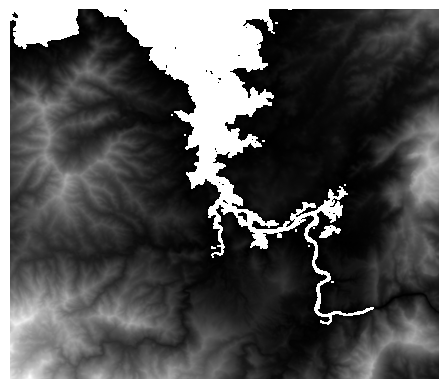

In [149]:
rgb = np.dstack([
    normalize(red),
    normalize(green),
    normalize(blue)
])

plt.imshow(rgb)
plt.axis('off')
plt.show()

In [150]:
rgb = xr.concat([
    masked_s2['red'].isel(time=0),
    masked_s2['green'].isel(time=0),
    masked_s2['blue'].isel(time=0)
], dim='band')
rgb.rio.to_raster('BArgb10.tif')